In [ ]:
%matplotlib inline
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import math


In [ ]:
!pip3 install tqdm

In [ ]:
img=cv.imread('/content/cybertruck.png')


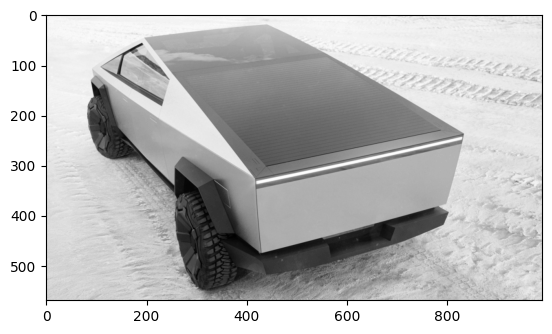

In [ ]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_ = plt.imshow(gray, cmap='gray')

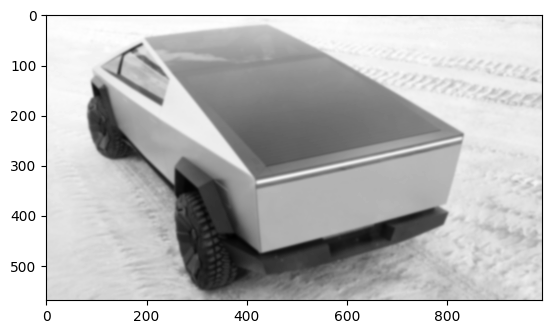

In [ ]:
#We apply gaussian blur to smooth out uneven pixels
#We define a kernel size of 21X21 of H and W
kernel_size=[21,21]
sigma=2
blurred_img=cv. GaussianBlur(gray,kernel_size,sigma)
_=plt.imshow(blurred_img,cmap='gray')

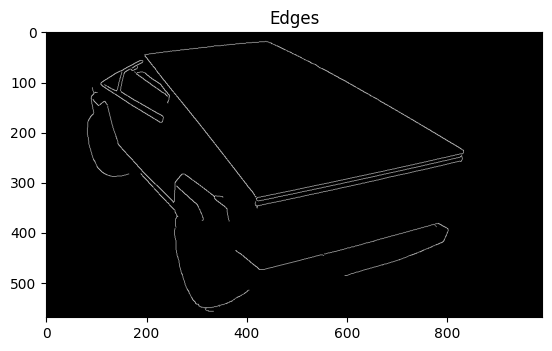

In [ ]:
#We can detect edges using the canny operator
apertureSize=3
# Detect edges using the Canny operator
edges_img = cv.Canny(blurred_img, 50, 150, apertureSize)
_=plt.imshow(edges_img, cmap='gray'), plt.title('Edges')



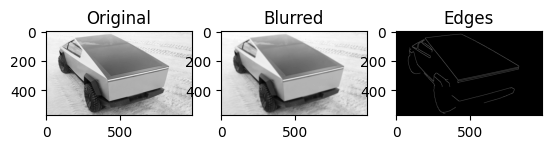

In [ ]:
# Display the original, blurred, and edges images
plt.subplot(1, 3, 1), plt.imshow(gray, cmap='gray'), plt.title('Original')
plt.subplot(1, 3, 2), plt.imshow(blurred_img, cmap='gray'), plt.title('Blurred')
plt.subplot(1, 3, 3), plt.imshow(edges_img, cmap='gray'), plt.title('Edges')
plt.show()

In [ ]:
threshold = 150
distance_resolution = 1 # 1 pixel increments
angular_resolution = math.pi/180.0 * 1 # 1 degree increments

lines = cv.HoughLines(edges_img, distance_resolution, angular_resolution, threshold)

In [ ]:
#each line is represented by (rho, theta), where rho is a distance and theta is the line's angle (in radians)
# the line uses this formula: rho = x cos theta + y sin theta
lines[:10]


array([[[ 412.       ,    1.3613569]],

       [[-213.       ,    2.0943952]],

       [[ 419.       ,    1.3613569]],

       [[-127.       ,    2.4783676]],

       [[ 572.       ,    1.3089969]],

       [[-121.       ,    2.4609141]],

       [[ 437.       ,    1.3439035]],

       [[ 427.       ,    1.3613569]],

       [[-202.       ,    2.0769417]]], dtype=float32)

In [ ]:
def calc_y(x, rho, theta):
    if theta == 0:
        return rho
    else:
        return (-math.cos(theta) / math.sin(theta)) * x + (rho / math.sin(theta))

height, width, _ = img.shape

def polar_to_xy(rho, theta):
    x1 = 0
    x2 = width
    y1 = int(calc_y(0, rho, theta))
    y2 = int(calc_y(width, rho, theta))
    return (x1, y1), (x2, y2)

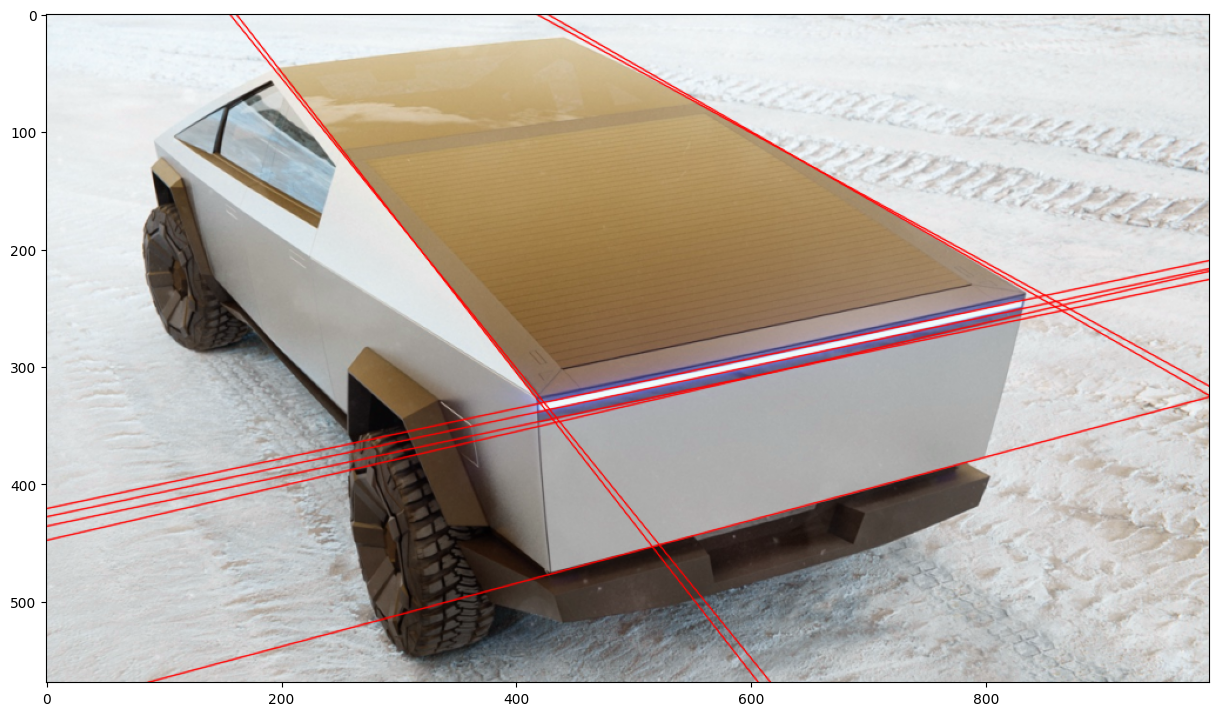

In [ ]:
image_output = img.copy()

red = (255, 0, 0)

for rho, theta in lines[:,0,]:
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv.line(image_output, (x1, y1), (x2, y2), red, 1, cv.LINE_AA)

plt.figure(figsize=(15, 10))
plt.imshow(image_output)

In [ ]:
#We start the hough transform
# High resolution lines will give us better hough transform
distance_resolution = 2
angular_resolution = math.pi/180.0 / 6

height, width, _ = img.shape

# the maximum possible line length
max_rho = math.sqrt(width**2 + height**2)

# the number of linear steps (+/- max rho)
num_rho = int(2 * max_rho / distance_resolution) - 1
max_rho = num_rho * distance_resolution / 2

# the number of discrete angular steps
num_theta = int(math.pi / angular_resolution)

# we make a blank "accumulator" 2d array
# each point = one line
accumulator = np.zeros((num_rho, num_theta)).astype(np.int32)
accumulator.shape

(1140, 1080)

In [ ]:
# loop through each point in the image
# this is a slightly more optimised version of the above

for x in range(0, width):
    for y in range(0, height):

        # get edge colour - will be either 0 (black), or 255 (white)
        edge_colour = edges_img[y, x]

        # if there's an edge
        if edge_colour != 0:

            # array of each of the discrete values of theta
            # (based on our angular resolution - from 0 to pi radians)
            theta_arr = np.arange(0, math.pi, angular_resolution)

            # solve for the corresponding rho using the line equation
            rho_arr = x * np.cos(theta_arr) + y * np.sin(theta_arr)

            # we then round each of the allowed discrete values of rho
            # This will give us a locus of points lying approximately on a sinusoidal
            # curve for each edge point (x, y)
            rho_index_arr = np.rint(rho_arr/distance_resolution + num_rho/2).astype(np.int32)
            theta_index_arr = np.rint(theta_arr/angular_resolution).astype(np.int32)

            acc = np.bincount(rho_index_arr * accumulator.shape[1] + theta_index_arr)
            acc.resize(accumulator.shape)

            # increment by one each of the points in our accumulator matrix
            # that make up this sinusoidal curve
            accumulator += acc

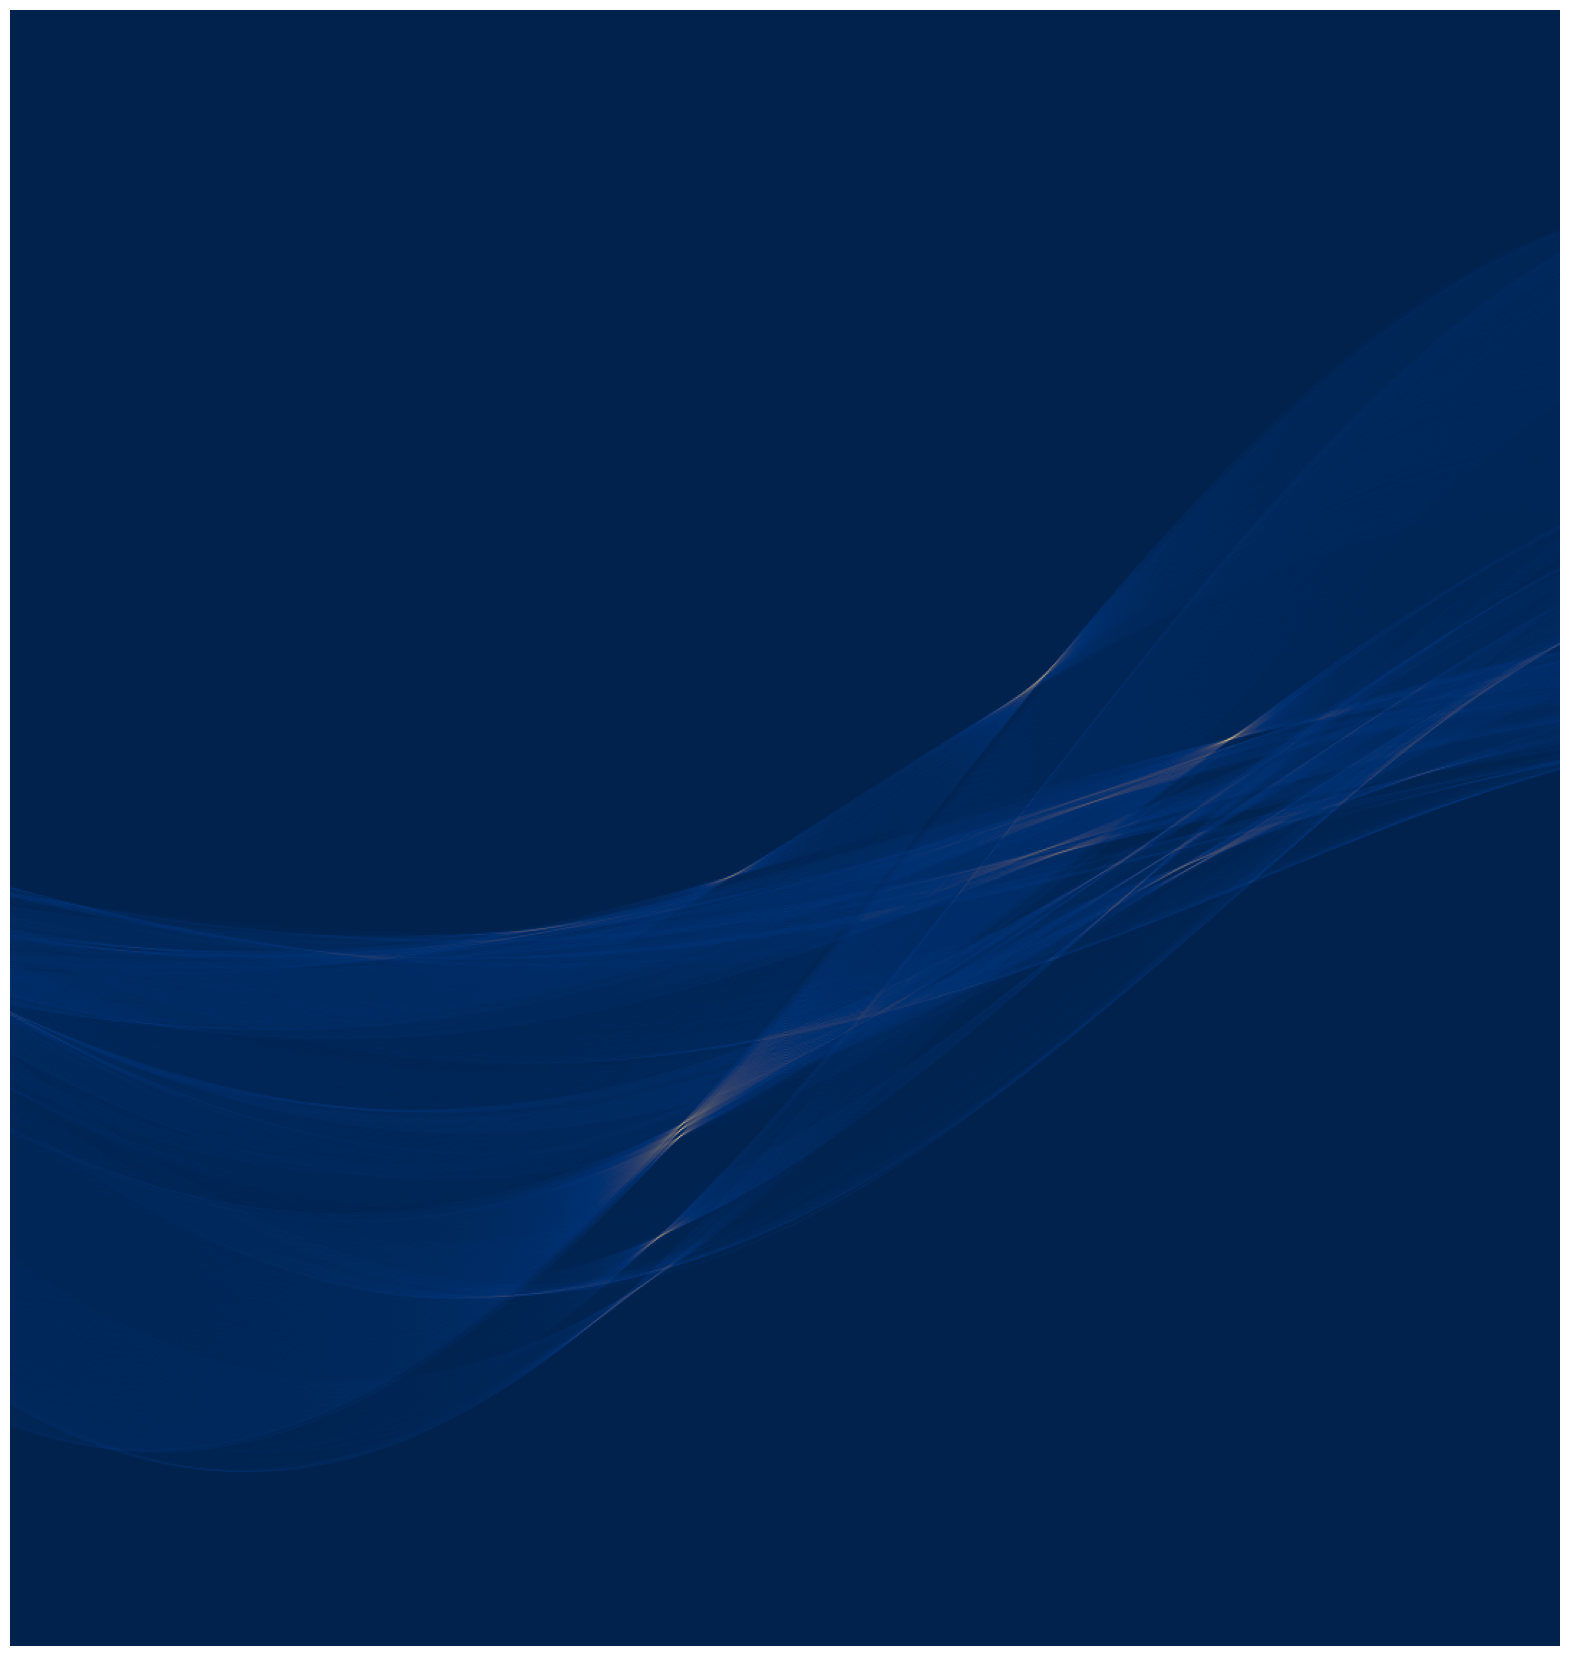

In [ ]:
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='cividis')
plt.xlabel('theta')
plt.ylabel('rho')
plt.axis('off')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator.png', bbox_inches=extent, pad_inches=0)

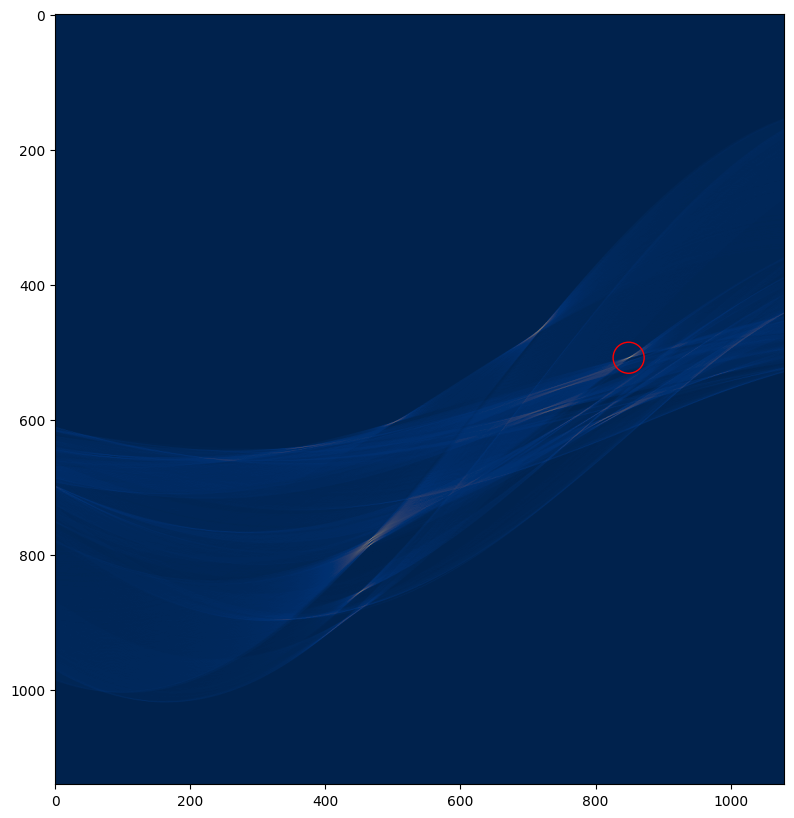

In [ ]:
#finding the max point i.e the edge points from the a ove sinusoidal curves
max_rho_index, max_theta_index = np.unravel_index(accumulator.argmax(axis=None), accumulator.shape)
(max_rho_index, max_theta_index)
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='cividis')
_ = plt.scatter(max_theta_index, max_rho_index, 500, color='r', facecolors='none', marker='o')

In [ ]:
max_rho_val = (max_rho_index - num_rho/2) * distance_resolution
max_theta_val = max_theta_index * angular_resolution
max_rho_val, max_theta_val

(-124.0, 2.4696408915719763)

In [ ]:
#converting the parametric cordinates to x and y coordinates
(x1, y1), (x2, y2) = polar_to_xy(max_rho_val, max_theta_val)
(x1, y1), (x2, y2)

((0, -199), (990, 1045))

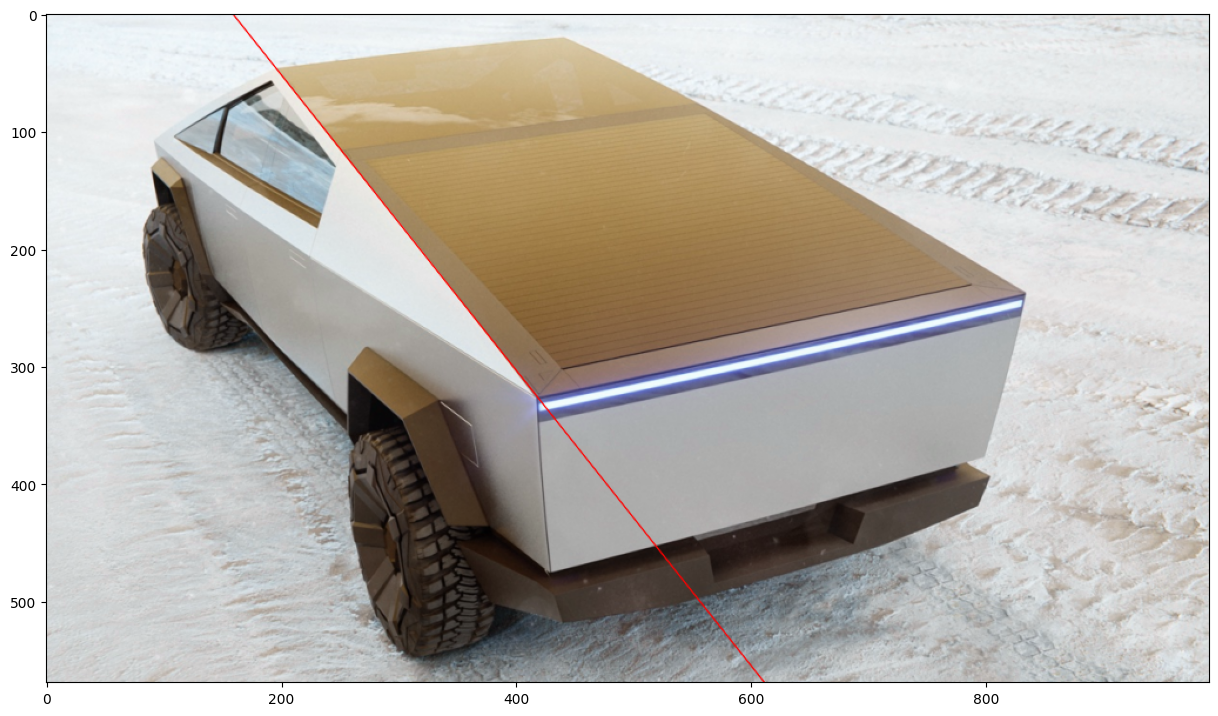

In [ ]:
# draw line on image
max_line_img = img.copy()
cv.line(max_line_img, (x1, y1), (x2, y2), red, 1, cv.LINE_AA)
plt.figure(figsize=(15, 10))
plt.imshow(max_line_img)

(array([6.7210e+03, 5.1090e+03, 1.1866e+04, 1.3140e+04, 1.1330e+04,
        4.6349e+04, 5.5720e+04, 4.6215e+04, 1.5757e+04, 2.3986e+04,
        1.8705e+04, 1.7765e+04, 7.8870e+03, 1.2051e+04, 9.4050e+03,
        8.2890e+03, 7.0980e+03, 2.9760e+03, 5.0320e+03, 3.8210e+03,
        3.1330e+03, 1.3850e+03, 2.3550e+03, 1.8520e+03, 1.5330e+03,
        6.4200e+02, 1.0920e+03, 9.2300e+02, 7.8300e+02, 6.2000e+02,
        2.7200e+02, 5.2800e+02, 4.4500e+02, 4.0700e+02, 2.0400e+02,
        3.2700e+02, 3.1900e+02, 2.4400e+02, 1.1000e+02, 2.1200e+02,
        2.0500e+02, 1.4900e+02, 1.3800e+02, 6.0000e+01, 1.3500e+02,
        1.0700e+02, 1.1200e+02, 4.2000e+01, 7.6000e+01, 8.0000e+01,
        5.8000e+01, 3.5000e+01, 6.1000e+01, 5.0000e+01, 4.5000e+01,
        5.3000e+01, 2.0000e+01, 3.3000e+01, 4.0000e+01, 2.9000e+01,
        1.4000e+01, 3.0000e+01, 2.8000e+01, 2.3000e+01, 1.0000e+01,
        2.6000e+01, 1.9000e+01, 1.4000e+01, 6.0000e+00, 1.2000e+01,
        1.7000e+01, 1.0000e+01, 2.2000e+01, 5.00

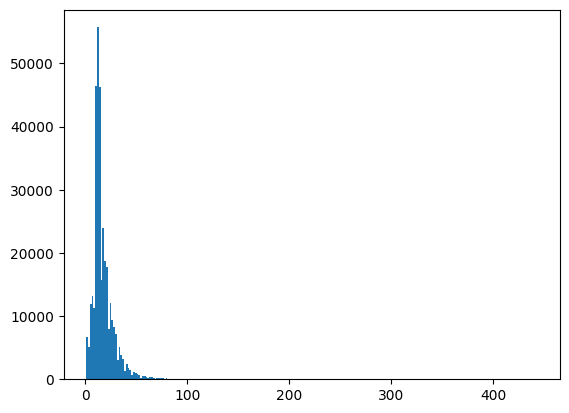

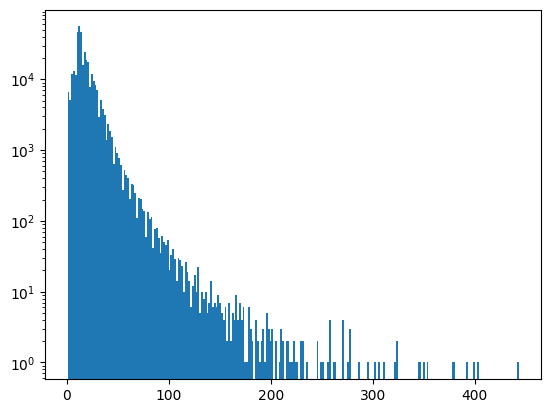

In [ ]:
#Now we check for thresholding limits
# Plot histogram of accumulator, to see what threshold is appropriate
flat = accumulator.flatten()
plt.figure()
plt.hist(flat[flat > 0], bins=250)
plt.figure()
plt.hist(flat[flat > 0], bins=250, log=True)


(650.0, 1000.0)

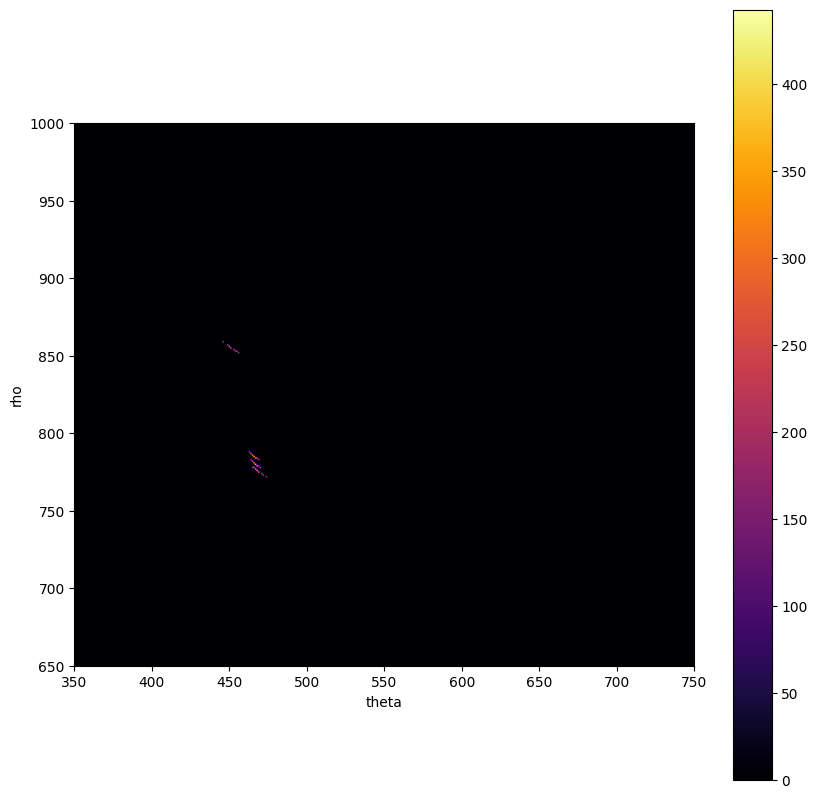

In [ ]:
threshold = 200
thresholded_accumulator = accumulator.copy()
thresholded_accumulator[thresholded_accumulator <= threshold ] = 0

plt.figure(figsize=(10, 10))
plt.imshow(thresholded_accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')
plt.colorbar()

plt.xlim(350, 750)
plt.ylim(650, 1000)

In [ ]:
from skimage.feature import peak_local_max

In [ ]:
min_distance = 7
coordinates = peak_local_max(thresholded_accumulator, min_distance=min_distance)
print(coordinates.shape)
print(coordinates[:])

(5, 2)
[[508 849]
 [780 467]
 [464 720]
 [855 451]
 [603 503]]


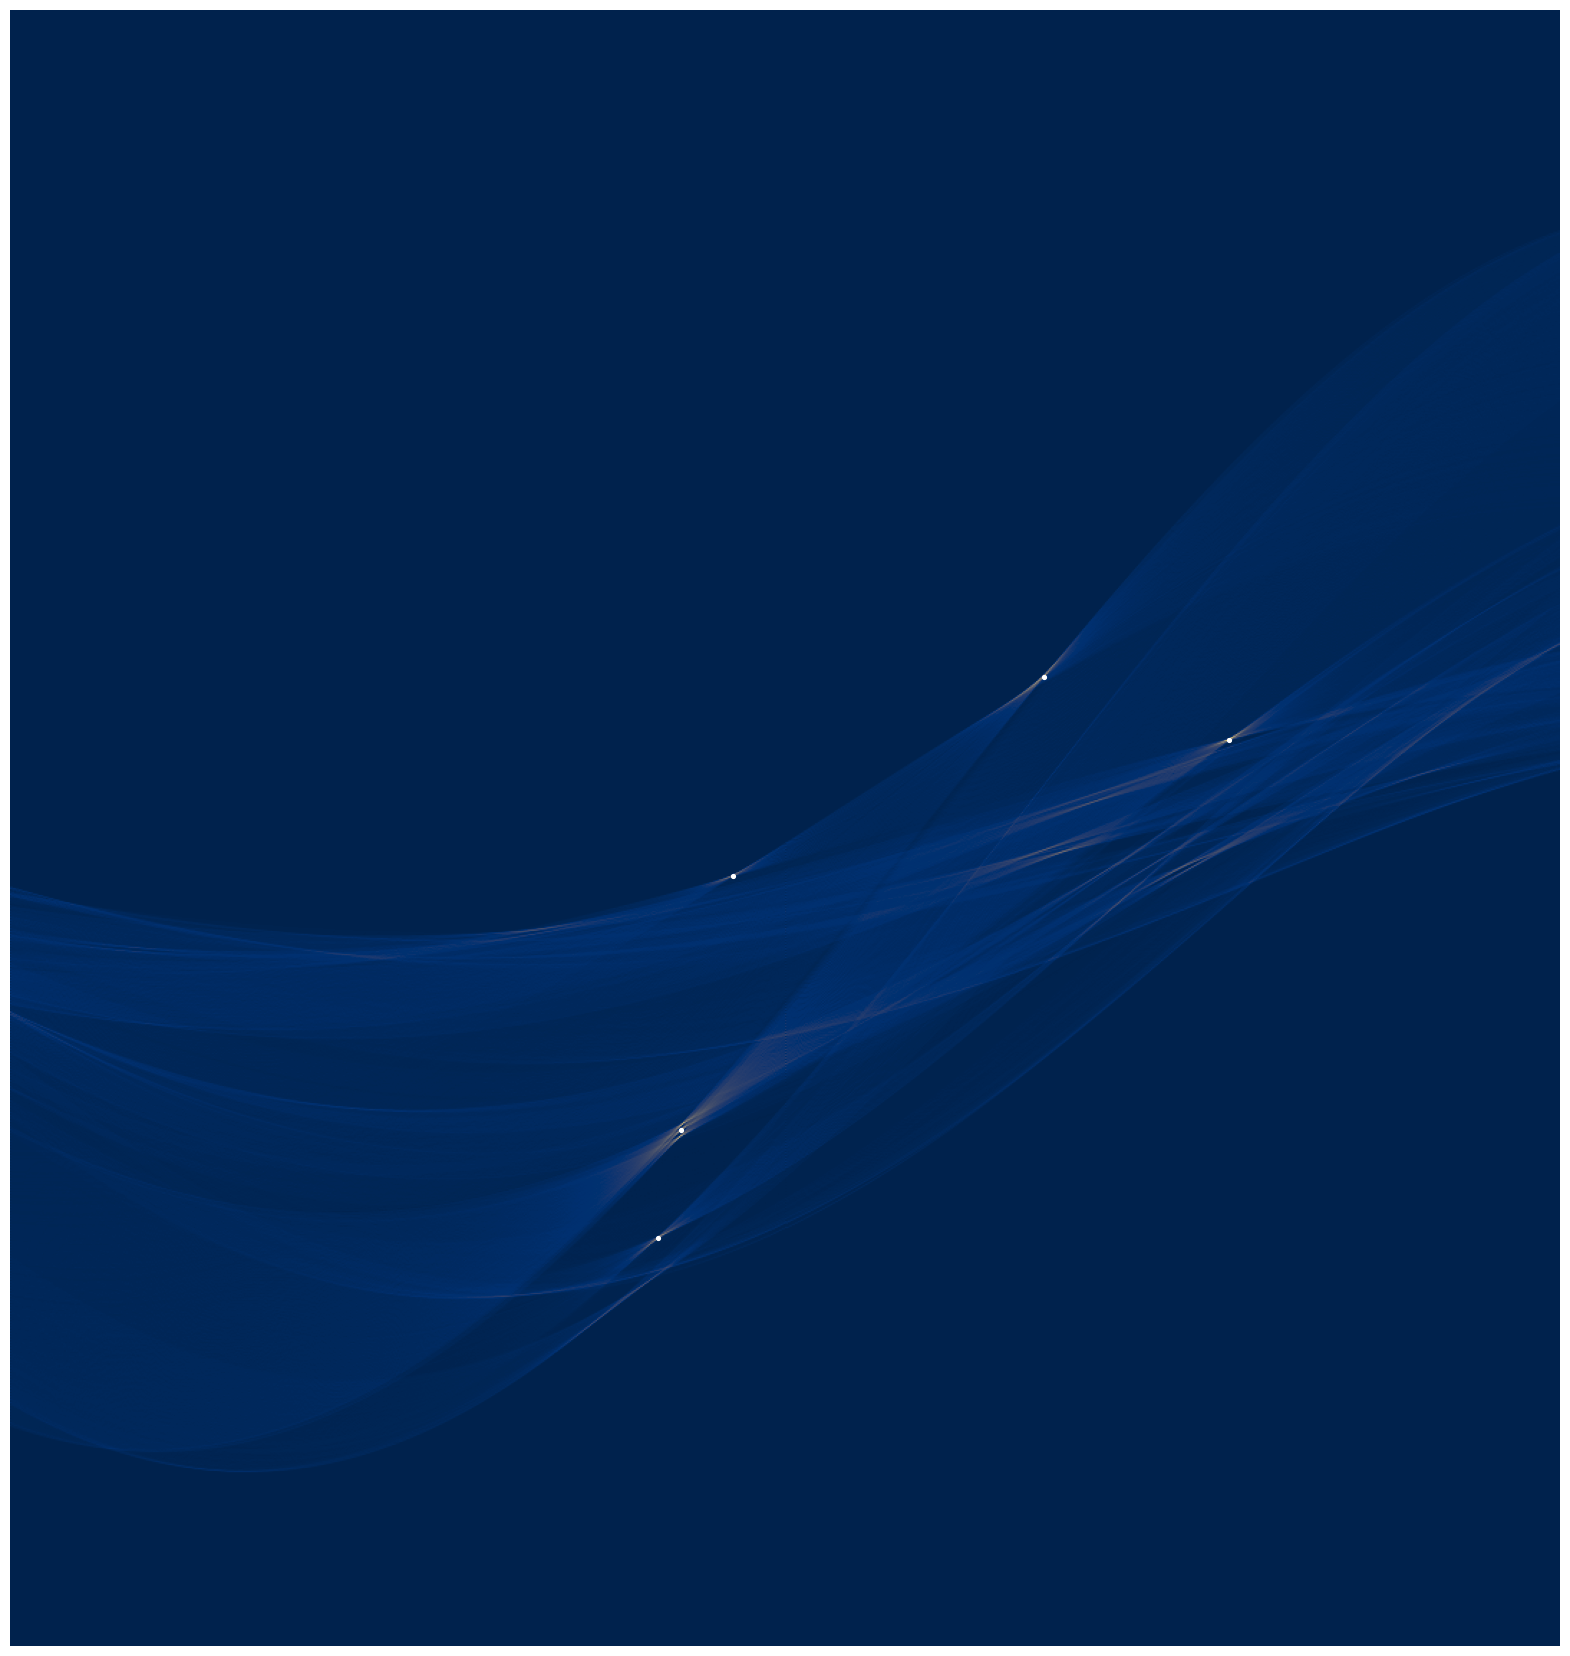

In [ ]:
# circle the local peaks / maxima
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='cividis')
plt.axis('off')
plt.scatter(coordinates[:,1], coordinates[:,0], 30, color='w', marker='.')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator_points.png', bbox_inches=extent, pad_inches=0)


True

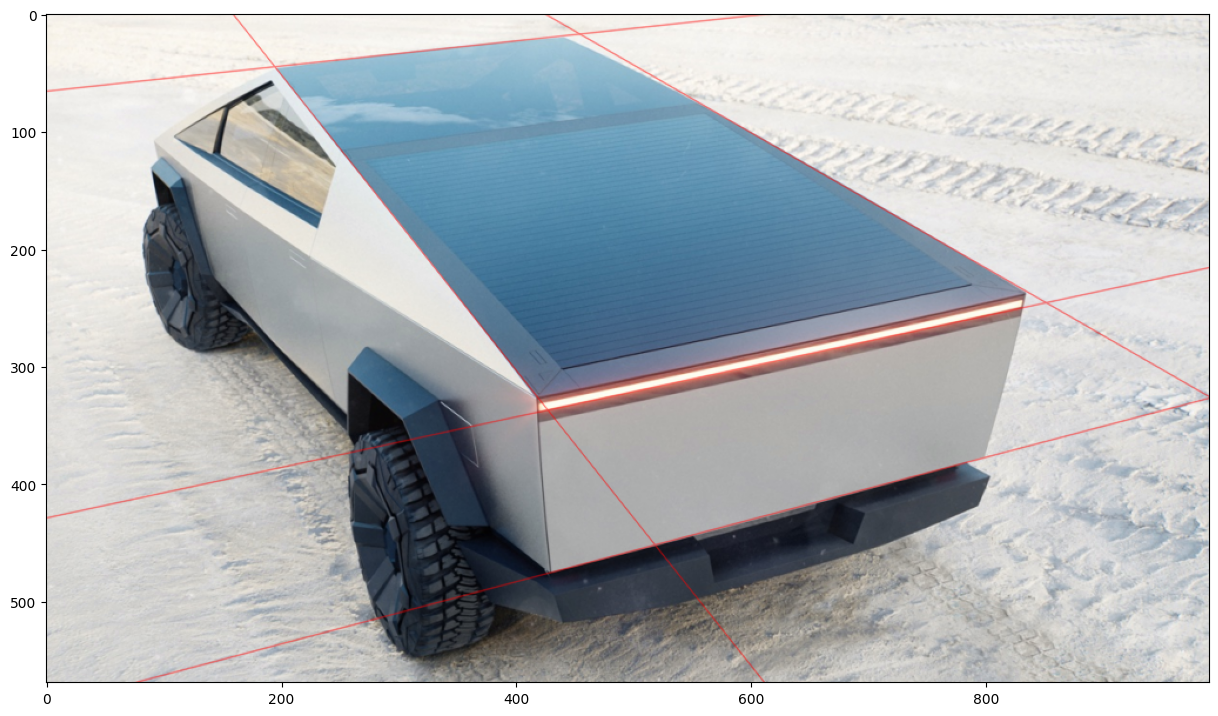

In [ ]:
# Now convert all these points back to lines,
# and draw lines on a copy of the image
image_output = img.copy()

red = (0, 0, 255)

for rho_index, theta_index in coordinates:
    rho = (rho_index - num_rho/2) * distance_resolution
    theta = theta_index * angular_resolution
#     print((rho_index, theta_index), (rho, theta))
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv.line(image_output, (x1, y1), (x2, y2), red, 1, cv.LINE_AA)

# 50% "transparency" lines
image_output = cv.addWeighted(img.copy(), 0.5, image_output, 0.5, 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv.cvtColor(image_output, cv.COLOR_RGB2BGR)) # expects RGB not BGR
cv.imwrite('output.png', image_output) # write as BGR